1. Set Up Dependencies

In [50]:
!python3 -m venv venv 
!. venv/bin/activate 

In [76]:

# Install required packages (modify as needed)
!pip install numpy pandas matplotlib flask django opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu115

Looking in indexes: https://download.pytorch.org/whl/cu115libjpeg
ERROR: Could not find a version that satisfies the requirement torchvision==0.15 (from versions: none)
ERROR: No matching distribution found for torchvision==0.15


In [ ]:
# Example: Create a .vscode/settings.json file for Python linting and formatting
import os
os.makedirs('.vscode', exist_ok=True)
with open('.vscode/settings.json', 'w') as f:
    f.write('''{
    "python.linting.enabled": true,
    "python.linting.pylintEnabled": true,
    "python.formatting.provider": "black"
}''')
print("VS Code settings configured.")

VS Code settings configured.


In [1]:
import torchvision
print("torchvision version:", torchvision.__version__)

torchvision version: 0.22.1+cu126


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as v2
from torchvision.models.segmentation import fcn_resnet50
from torchvision.io import read_image, write_png
from torchvision import tv_tensors
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import os
import glob

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, color_transform=None):
        self.images_dir = images_dir
        self.images = sorted(glob.glob(os.path.join(images_dir, '*', '*.png'))) 
        self.mask_dir = masks_dir
        self.transform = transform
        self.color_transform = color_transform

        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = image_path.replace(self.images_dir, self.mask_dir)
        mask_path = mask_path.replace('frame_', 'mask_')
        
        image = tv_tensors.Image(read_image(image_path))
        mask = tv_tensors.Mask(read_image(mask_path))
        if self.transform:
            image, mask = self.transform(image, mask)
        image = image.float() / 255.0  # Normalize image to [0, 1] range
        mask = mask.long()  # Ensure mask is of type long for segmentation tasks
        if self.color_transform:
            image = self.color_transform(image)
        mask = mask.squeeze(0)  # Remove channel dimension if mask is single-channel

        return image, mask

In [4]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, n_layers=4):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # Encoder (downsampling)
        self.inc = self._double_conv(n_channels, 32)
        self.down_layers = nn.ModuleList()
        for i in range(n_layers):
            self.down_layers.add_module(f'down{i+1}', self._down(32 * (2**i), 32 * (2**(i+1))))
        
        # Decoder (upsampling)
        self.first_deconv = nn.ConvTranspose2d(32*(2**n_layers), 32*(2**(n_layers-1)), kernel_size=2, stride=2)
        self.up_layers = nn.ModuleList()
        for i in range(n_layers - 1):
            self.up_layers.add_module(f'up{i+1}', self._up(32 * (2**(n_layers - i - 1)), 32 * (2**(n_layers - i - 2))))
        self.outc = nn.Sequential(
            self._double_conv(64, 32),
            nn.Conv2d(32, n_classes, kernel_size=1)
        )
        
    def forward(self, x):
        x1 = self.inc(x)
        x_prev = []
        for down in self.down_layers:
            x_prev.append(down(x1 if len(x_prev) == 0 else x_prev[-1]))
        
        
        x_up = [self.first_deconv(x_prev[-1])] # First upsampled layer
        for up in self.up_layers:
            x_up.append(up(torch.cat([x_prev[-(len(x_up) + 1)], x_up[-1]], dim=1)))
        outc_in = torch.cat([x1, x_up[-1]], dim=1)
        logits = self.outc(outc_in)
        
        
        return logits
    
    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _down(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(2),
            self._double_conv(in_channels, out_channels)
        )
    
    def _up(self, in_channels, out_channels):
        return nn.Sequential(
            self._double_conv(2*in_channels, in_channels),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        )

In [5]:
# Loss function (CrossEntropyLoss for multi-class segmentation)
criterion = nn.CrossEntropyLoss()

# IoU metric for evaluation
def iou_score(outputs, targets):
    smooth = 1e-6
    outputs = torch.argmax(outputs, dim=1)
    
    intersection = (outputs & targets).float().sum((1, 2))
    union = (outputs | targets).float().sum((1, 2))
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    
    best_val_iou = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_iou += iou_score(outputs, masks) * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_iou /= len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
                val_iou += iou_score(outputs, masks) * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')
        
        # Save best model
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model

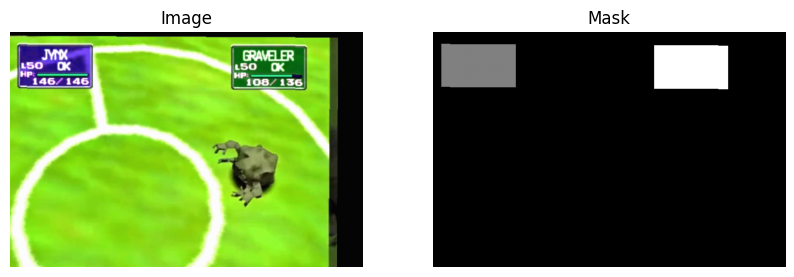

In [ ]:
%matplotlib inline
from torch.utils.data import DataLoader, random_split
import random

# Example DataLoader with memory optimization
image_dir = '/home/tmelanson/stadium_dataset/images'  # Adjust this path as needed
mask_dir = '/home/tmelanson/stadium_dataset/masks'  # Adjust this path as needed

# Define transforms
# 1. Apply random translation and rotation to images and masks
transform = v2.Compose([
    v2.RandomAffine(degrees=0, translate=(0.15, 0.05)),
])
# 2. For image transformation, add color jitter
color_transform = v2.Compose([
    v2.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.2, hue=0.1),
])

dataset = SegmentationDataset(image_dir, mask_dir, transform=transform, color_transform=color_transform)

# Display example images from the dataset
def show_example_images(dataset, num_images=5):
    indices = random.sample(range(len(dataset)), num_images)

    for i in indices:
        image, mask = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
        mask = mask.numpy()
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        
        plt.show()

show_example_images(dataset, num_images=1)


In [ ]:
# Initialize model (either custom U-Net or pretrained model)
# Option 1: Custom U-Net
model = UNet(n_channels=3, n_classes=3, n_layers=3)

# Option 2: Pretrained FCN ResNet50
# model = fcn_resnet50(pretrained=True)
# model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)
# Split dataset into training and validation sets
dataset_size = len(dataset)
val_size = int(0.2 * dataset_size)  # 20% for validation
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10
Train Loss: 0.0648, Train IoU: 0.9062
Val Loss: 0.0339, Val IoU: 0.9448
Epoch 2/10
Train Loss: 0.0309, Train IoU: 0.9482
Val Loss: 0.0298, Val IoU: 0.9578
Epoch 3/10
Train Loss: 0.0287, Train IoU: 0.9531
Val Loss: 0.0281, Val IoU: 0.9595
Epoch 4/10
Train Loss: 0.0274, Train IoU: 0.9558
Val Loss: 0.0276, Val IoU: 0.9592


In [72]:
torch.save(trained_model.state_dict(), 'unet_trained.pth')

In [1]:
def predict(model, image_path, transform):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    image = Image.open(image_path).convert("RGB")
    if transform:
        input_tensor = transform(image).unsqueeze(0).to(device)
    else:
        input_tensor = v2.ToTensor()(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    return image, prediction

# Visualize prediction
def visualize_prediction(image_path, prediction, ax1, ax2):
    image = Image.open(image_path).convert("RGB")
    ax1.imshow(image)
    ax1.title("Original Image")
    ax2.imshow(prediction, cmap='viridis')
    ax2.title("Segmentation Prediction")

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cv2
IMG_DIR= '/home/tmelanson/battle4'  # Adjust this path as needed

matplotlib.use('TkAgg')  # Use TkAgg backend for interactive plotting
plt.ion()

from matplotlib.animation import FuncAnimation

model = UNet(n_channels=3, n_classes=3, n_layers=3)  # Use the same model architecture as trained
model.load_state_dict(torch.load('unet_trained.pth'))
fig, (ax_img, ax_pred) = plt.subplots(1, 2, figsize=(12, 6))
ax_img.set_title('Image')
ax_pred.set_title('Prediction')
img_img = ax_img.imshow(np.zeros((256, 256, 3)), animated=True)  # Placeholder for image 
img_pred = ax_pred.imshow(np.zeros((256, 256)), cmap='viridis', vmin=0, vmax=3, animated=True)  # Placeholder for prediction
img_keyword = 'frame' # Adjust this keyword based on your image naming convention


def init():
    # Initialize the model and load the best weights
    global model
    img_file =  os.path.join(IMG_DIR, f'{img_keyword}_000100.png')  # Adjust this path as needed
    img, pred = predict(model, img_file, None)
    img_img.set_array(np.array(img))
    img_pred.set_array(pred)
    return [img_img, img_pred]


def update(i: int):
    # Initialize the model and load the best weights
    global model
    img_file =  os.path.join(IMG_DIR, f"{img_keyword}_{i:06d}.png")  # Adjust this path as needed
    img, pred = predict(model, img_file, None)
    # Get prediction contours, and bounding boxes from that
    np_img = np.zeros_like(img)
    contours, _ = cv2.findContours(pred.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    list(contours).sort(key=lambda x: cv2.contourArea(x), reverse=True)  # Sort contours by area
    for contour in contours:
        if cv2.contourArea(contour) < 100: 
            continue 
        # Get bounding box for the contour
        x, y, w, h = cv2.boundingRect(contour)
        np_img[y:y+h, x:x+w] = img.crop((x, y, x+w, y+h))
    img_img.set_array(np_img)
    img_pred.set_array(pred)
    return [img_img, img_pred]

plt.tight_layout()
ani = FuncAnimation(fig, update, frames=range(100, 2000), init_func=init, repeat=True, interval=100)
# Save the animation as a video file
# ani.save('segmentation_animation_b2.mp4', writer='ffmpeg', fps=30, dpi=300)
plt.show(block=True)

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.use('TkAgg')  # Use TkAgg backend for interactive plotting
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.ion()

def create_animation():
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Initial data (empty images or starting point)
    data1 = np.random.rand(10, 12)
    data2 = np.random.rand(8, 10)
    
    # Create initial imshow plots with empty data
    im1 = ax1.imshow(data1, cmap='viridis', animated=True)
    im2 = ax2.imshow(data2, cmap='plasma', animated=True)
    
    # Add colorbar for each subplot
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)
    
    # Set titles
    ax1.set_title("First Image")
    ax2.set_title("Second Image")
    
    # Initialization function
    def init():
        # This is called at the start of animation
        im1.set_array(np.zeros_like(data1))
        im2.set_array(np.zeros_like(data2))
        return [im1, im2]
    
    # Update function for animation
    def update(frame):
        # Generate new data (in a real app, you'd get this from your data source)
        new_data1 = np.random.rand(10, 12) + frame * 0.01
        new_data2 = np.random.rand(8, 10) - frame * 0.01
        
        # Update the data in each image
        im1.set_array(new_data1)
        im2.set_array(new_data2)
        
        # Optionally update color scaling if needed
        im1.set_clim(new_data1.min(), new_data1.max())
        im2.set_clim(new_data2.min(), new_data2.max())
        
        return [im1, im2]
    
    # Create animation
    ani = FuncAnimation(fig, update, frames=100, init_func=init, 
                        blit=True, interval=100, repeat=True)
    
    plt.tight_layout()
    return ani, fig

# Create and display the animation
animation, fig = create_animation()

# To save the animation (optional)
# animation.save('animation.mp4', writer='ffmpeg')

plt.show(block=True)

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [ ]:
# Example: Create a .vscode/settings.json file for Python linting and formatting
import os
os.makedirs('.vscode', exist_ok=True)
with open('.vscode/settings.json', 'w') as f:
    f.write('''{
    "python.linting.enabled": true,
    "python.linting.pylintEnabled": true,
    "python.formatting.provider": "black"
}''')
print("VS Code settings configured.")

VS Code settings configured.
